# Part 3 - Rental Price Prediction

### Content  
- [Section 1 - Data Pre-processing](#section-1)  
- [Section 2 - Modeling - Multi-Linear Regression](#section-2)  
- [Section 3 - Modeling - Random Forest Regressor](#section-3)  
- [Section 4 - Modeling - XGBoost Regressor](#section-4)  
- [Section 5 - Modeling - LightGBM Regressor](#section-5)  
- [Section 6 - Modeling - CatBoost Regressor](#section-6)  
- [Section 7 - Compare Models](#section-7)
- [Section 8 - Explore Best Models](#section-8)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from scipy.stats import uniform, randint
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import warnings
warnings.filterwarnings("ignore")

___
<a name="section-1"></a>
## (1) Data Pre-Processing

In [4]:
condo_df = pd.read_csv('./Data/condo_dataset_preprocessed.csv')

#### Drop unnecessary columns

In [5]:
condo_df.columns

Index(['amenities', 'beds', 'developer', 'district', 'electoral_div', 'lease',
       'name', 'nearest_mrt_name', 'neighbourhood', 'property_type', 'rental',
       'sqft', 'tenure', 'travel_time_changi', 'travel_time_orchard',
       'travel_time_raffles', 'furnishing', 'amenities_count',
       'nearest_mrt_dist_min', 'nearest_mrt_dist_metres', 'freehold_status',
       'rental_log'],
      dtype='object')

In [6]:
cols_to_drop = ['name','beds','developer','electoral_div','neighbourhood','rental','nearest_mrt_name',
                'property_type','amenities_count','nearest_mrt_dist_min','nearest_mrt_dist_metres',
                'furnishing','tenure','freehold_status', 'travel_time_raffles']

In [7]:
condo_df_sm = condo_df.drop(columns = cols_to_drop)
condo_df_sm.head()

,amenities,district,lease,sqft,travel_time_changi,travel_time_orchard,rental_log
0,"'Clubhouse', 'Gym', 'Spa Pool', 'Swimming Pool...",D09,Flexible,2100,53,12,9.159047
1,"'Aircon', 'Gym', 'Swimming Pool', 'Wading Pool...",D09,Flexible,1399,56,12,8.853665
2,"'Bathtub', 'Aircon', 'Maid Room', 'Gym', 'Park...",D05,greater_than_or_equal_24m,1948,70,27,8.732305
3,"'Jogging Track', 'Multi-purpose Hall', 'Hammoc...",D22,Flexible,775,85,46,7.937375
4,"'Security', 'Jacuzzi', 'Lap Pool', 'Tennis Cou...",D15,Flexible,635,46,41,7.783224


#### Generate amenities of interest

In [8]:
# Identify the amenities that will likely impact rental price (based on own assumptions and business understanding)
key_amenities = ['Balcony','High Floor','Renovated','City View','Greenery View','Steam Room','Sauna']

In [9]:
# Create one-hot encoded column for each amenity
condo_df_with_amenities = condo_df_sm.copy()

for amenity in key_amenities:
    amenity_name = amenity.lower().replace(' ','_')
    condo_df_sm[f'{amenity_name}'] = condo_df_sm['amenities'].str.contains(f'{amenity}')*1 # Multiply by 1 to convert boolean into integer

In [10]:
# Drop original amenities column
condo_df_sm.drop(columns = ['amenities'], inplace = True)

In [11]:
condo_df_sm.head()

,district,lease,sqft,travel_time_changi,travel_time_orchard,rental_log,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna
0,D09,Flexible,2100,53,12,9.159047,0,0,0,0,0,1,0
1,D09,Flexible,1399,56,12,8.853665,0,0,0,0,0,0,0
2,D05,greater_than_or_equal_24m,1948,70,27,8.732305,1,1,0,0,0,0,0
3,D22,Flexible,775,85,46,7.937375,0,0,0,0,0,0,0
4,D15,Flexible,635,46,41,7.783224,0,0,0,0,0,0,0


___
<a name="section-2"></a>
## (2) Modeling - Multi-Linear Regression

In [12]:
# Generate dummy columns (while dropping first dummy col (drop_first = True) to prevent collinearity)
condo_df_lr = condo_df_sm.copy()
condo_df_lr = pd.get_dummies(condo_df_lr, columns = ['district'], drop_first = True)
condo_df_lr = pd.get_dummies(condo_df_lr, columns = ['lease'], drop_first = True)

In [13]:
condo_df_lr.head()

,sqft,travel_time_changi,travel_time_orchard,rental_log,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_greater_than_or_equal_24m,lease_less_than_24m
0,2100,53,12,9.159047,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1399,56,12,8.853665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1948,70,27,8.732305,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,775,85,46,7.937375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,635,46,41,7.783224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Separate dependent(target) variable and independent variables
X = condo_df_lr.drop(['rental_log'], axis = 1)
y = condo_df_lr['rental_log']

In [15]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [17]:
# Carry out standardization on numerical columns
scaler = StandardScaler() 
numerical_cols = ['sqft','travel_time_changi','travel_time_orchard']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

In [18]:
X_train.head()

,sqft,travel_time_changi,travel_time_orchard,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_greater_than_or_equal_24m,lease_less_than_24m
565,-0.439148,0.423685,0.050195,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1883,-0.451719,-1.236609,0.329411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2458,-0.562578,-0.624922,-0.322093,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
640,-0.255146,1.647059,1.167059,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3396,0.101428,1.122756,0.329411,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [20]:
# Intercept
linear_reg.intercept_

8.470341200300448

In [21]:
# Display coefficients
coeff = pd.DataFrame([X_train.columns, linear_reg.coef_]).T
coeff = coeff.rename(columns={0: 'Feature', 1: 'Coefficients'})
coeff.sort_values(by='Coefficients', ascending = False)

,Feature,Coefficients
0,sqft,0.437364
12,district_D04,0.166045
8,steam_room,0.0425135
4,high_floor,0.0315527
36,lease_greater_than_or_equal_24m,0.0205341
3,balcony,0.0194805
10,district_D02,0.0115551
6,city_view,0.00758788
1,travel_time_changi,0.000700308
13,district_D05,-0.00191622


#### Evaluate model on training set

In [22]:
y_pred_train = linear_reg.predict(X_train)

In [23]:
# Model evaluation
print('R^2',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

R^2 0.8151764084387296
Adjusted R^2 0.8139677874648305
MAE 0.17588124790224816
MSE 0.055517712234659435
RMSE 0.23562196891346832


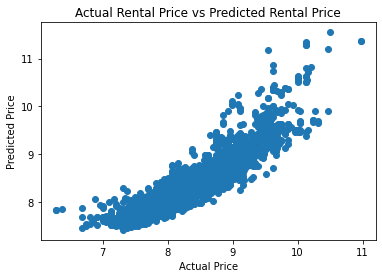

In [24]:
# Visualizing actual prices vs predicted values
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Rental Price vs Predicted Rental Price")
plt.show()

### Performing checks for multi-linear regression assumptions
Reference: https://www.statisticssolutions.com/assumptions-of-multiple-linear-regression

#### 1) Equal Error Variance (Homoscedasticity)

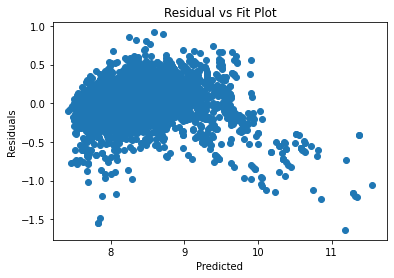

In [25]:
# Residual vs fit plot
plt.scatter(y_pred_train, y_train - y_pred_train)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

Homoscedasticity check shows some type of curvilinear pattern in the residual vs fit plot

#### 2) Normal Error (Multivariate Normality)

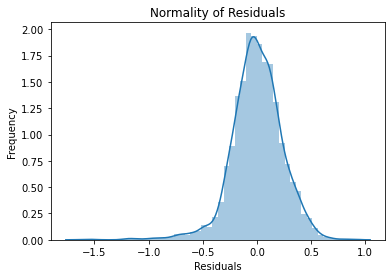

In [26]:
# Normality of residuals
sns.distplot(y_train-y_pred_train)
plt.title("Normality of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

The residuals are normally distributed, thus the normality assumption is satisfied

#### 3) Multi-Collinearity

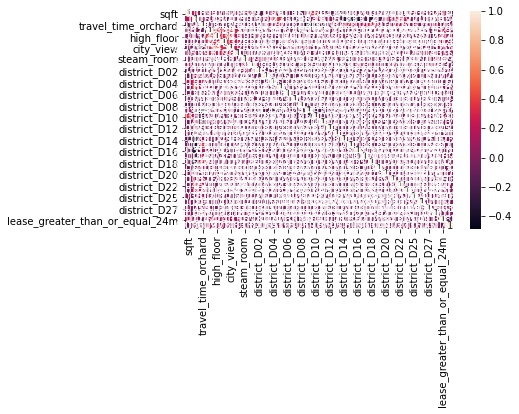

In [27]:
corrMatrix = X_train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [28]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [29]:
calc_vif(X_train)

,variables,VIF
0,sqft,1.309730
1,travel_time_changi,7.040767
2,travel_time_orchard,8.246217
3,balcony,1.906240
4,high_floor,1.784282
5,renovated,1.520663
6,city_view,1.717831
7,greenery_view,1.392665
8,steam_room,1.385042
9,sauna,1.348904


VIF values all below 10, so we pass this check.

#### 4) Linearity of independent variables with dependent variable

In [30]:
X_train.columns

Index(['sqft', 'travel_time_changi', 'travel_time_orchard', 'balcony',
       'high_floor', 'renovated', 'city_view', 'greenery_view', 'steam_room',
       'sauna', 'district_D02', 'district_D03', 'district_D04', 'district_D05',
       'district_D06', 'district_D07', 'district_D08', 'district_D09',
       'district_D10', 'district_D11', 'district_D12', 'district_D13',
       'district_D14', 'district_D15', 'district_D16', 'district_D17',
       'district_D18', 'district_D19', 'district_D20', 'district_D21',
       'district_D22', 'district_D23', 'district_D25', 'district_D26',
       'district_D27', 'district_D28', 'lease_greater_than_or_equal_24m',
       'lease_less_than_24m'],
      dtype='object')

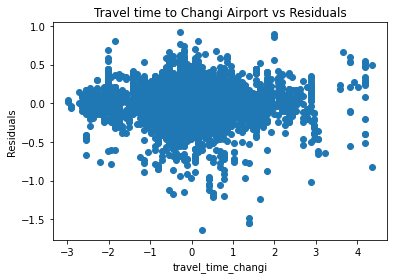

In [31]:
# Independence of X variables
plt.scatter(X_train['travel_time_changi'], y_train-y_pred_train)
plt.title("Travel time to Changi Airport vs Residuals")
plt.xlabel("travel_time_changi")
plt.ylabel("Residuals")
plt.show()

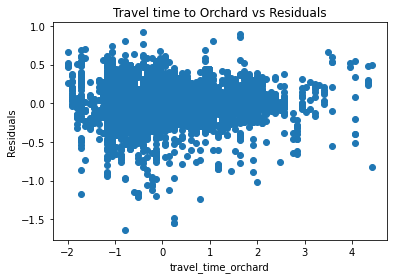

In [32]:
plt.scatter(X_train['travel_time_orchard'], y_train-y_pred_train)
plt.title("Travel time to Orchard vs Residuals")
plt.xlabel("travel_time_orchard")
plt.ylabel("Residuals")
plt.show()

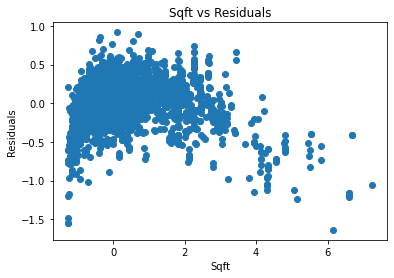

In [33]:
plt.scatter(X_train['sqft'], y_train-y_pred_train)
plt.title("Sqft vs Residuals")
plt.xlabel("Sqft")
plt.ylabel("Residuals")
plt.show()

The above sqft vs residuals plot seems to suggest some form of non-linearity

In [34]:
# Add sqft^2 (scaled) to deal with above non-linear band pattern
X_train_2 = X_train.copy()
X_train_2['sqft_squared'] = X_train_original['sqft'].apply(lambda x: x**2)
X_train_2[['sqft_squared']] = scaler.fit_transform(X_train_2[['sqft_squared']])
X_train_2.head()

,sqft,travel_time_changi,travel_time_orchard,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_greater_than_or_equal_24m,lease_less_than_24m,sqft_squared
565,-0.439148,0.423685,0.050195,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.377227
1883,-0.451719,-1.236609,0.329411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.381635
2458,-0.562578,-0.624922,-0.322093,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.417958
640,-0.255146,1.647059,1.167059,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.305969
3396,0.101428,1.122756,0.329411,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.131972


In [35]:
linear_reg.fit(X_train_2, y_train)
y_pred_train_2 = linear_reg.predict(X_train_2)

In [36]:
# Model evaluation
print('R^2',metrics.r2_score(y_train, y_pred_train_2))
print('Adjusted R^2',1 - (1-metrics.r2_score(y_train, y_pred_train_2))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE',metrics.mean_absolute_error(y_train, y_pred_train_2))
print('MSE',metrics.mean_squared_error(y_train, y_pred_train_2))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_2)))

R^2 0.8610678755585999
Adjusted R^2 0.8601593536641285
MAE 0.15211881944871028
MSE 0.04173273357438555
RMSE 0.20428591134580365


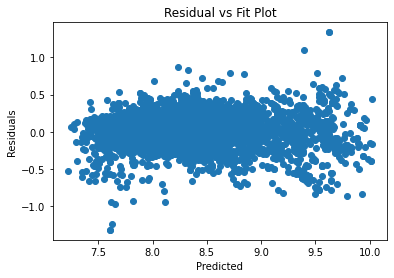

In [37]:
# Replot residual vs fit
plt.scatter(y_pred_train_2, y_train - y_pred_train_2)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

Homoscedasticity check is now passed

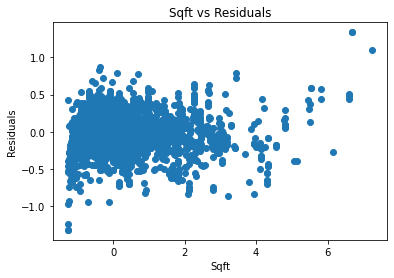

In [38]:
plt.scatter(X_train_2['sqft'], y_train-y_pred_train_2)
plt.title("Sqft vs Residuals")
plt.xlabel("Sqft")
plt.ylabel("Residuals")
plt.show()

Linearity check passed as well

The non-linear band seen earlier implies that adjacent error terms were correlated, and thus did not pass the independence test. After adding in the sqft^2 term into the model, the issue has been resolved and the independence assumption is satisfied. 

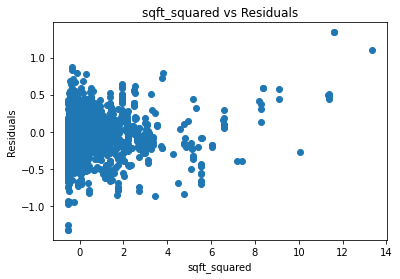

In [39]:
plt.scatter(X_train_2['sqft_squared'], y_train-y_pred_train_2)
plt.title("sqft_squared vs Residuals")
plt.xlabel("sqft_squared")
plt.ylabel("Residuals")
plt.show()

In [40]:
# Display coefficients
linear_reg_features = pd.DataFrame([X_train_2.columns, linear_reg.coef_]).T
linear_reg_features = linear_reg_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
linear_reg_features.sort_values(by='Importance Score', ascending = False)

,Feature,Importance Score
0,sqft,0.756256
12,district_D04,0.0969012
8,steam_room,0.033723
3,balcony,0.0289002
10,district_D02,0.0283956
14,district_D06,0.02523
4,high_floor,0.0208554
6,city_view,0.0161451
36,lease_greater_than_or_equal_24m,0.00155695
5,renovated,-0.0076446


#### Evaluation on test set

In [41]:
# Transform test set
X_test['sqft_squared'] = X_test_original['sqft'].apply(lambda x: x**2)
X_test[['sqft_squared']] = scaler.fit_transform(X_test[['sqft_squared']])

In [42]:
y_pred_test = linear_reg.predict(X_test)

In [46]:
# Store results as dataframe
lr_dict = {'Model':'Multi-Linear Regression',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

In [47]:
linear_reg_metrics = pd.DataFrame.from_dict(lr_dict, orient = 'index').T
linear_reg_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,Multi-Linear Regression,0.839631,0.835236,0.156129,0.0459387,0.214333


___
<a name="section-3"></a>
## (3) Modeling - Random Forest Regressor

In [48]:
condo_df = condo_df_sm.copy()
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) # Not dropping first col
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) # Not dropping first col

Use one-hot encoding instead of label encoding because the factors in district and lease are nominal, not ordinal.

In [27]:
# CODE for LabelEncoder (not to use for this exercise)
# Pre-processing for district values
# district_label_encoder = LabelEncoder()
# district_label_encoder.fit(X_train['district'])
# district_le_mapping = {l: i for i, l in enumerate(district_label_encoder.classes_)}
# print(district_le_mapping)

# # Fit transform X_train dataset
# X_train[['district']] = district_label_encoder.fit_transform(X_train[['district']])

In [49]:
condo_df.head()

,sqft,travel_time_changi,travel_time_orchard,rental_log,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D01,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_Flexible,lease_greater_than_or_equal_24m,lease_less_than_24m
0,2100,53,12,9.159047,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1399,56,12,8.853665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1948,70,27,8.732305,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,775,85,46,7.937375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,635,46,41,7.783224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

In [51]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
# Create the grid
param_grid = {
        'min_samples_leaf': [1,2,3],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 300, 600]
}

In [32]:
rf_reg = RandomForestRegressor(random_state = 42)

In [33]:
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = param_grid, cv=5, n_jobs=-1, verbose=2)

In [34]:
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.9min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 300, 600]},
             verbose=2)

In [35]:
rf_grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300}

In [36]:
# Get best RF estimator based on best parameters
rf_best = rf_grid.best_estimator_

# Use RF regressor to predict on test set
y_pred_test = rf_best.predict(X_test)

In [39]:
# Store results as dataframe
rf_dict = {'Model':'Random Forest Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

rf_reg_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T
rf_reg_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,Random Forest Regressor,0.925711,0.923567,0.0882945,0.0212806,0.145879


#### Feature Importance

In [40]:
rf_best.feature_importances_

array([8.38099413e-01, 2.62679373e-02, 3.52611624e-02, 7.16546395e-02,
       8.41319632e-04, 7.79823911e-04, 5.86366475e-04, 6.03209479e-04,
       4.82509646e-04, 2.63818698e-03, 3.15947912e-03, 7.01822029e-04,
       6.81373228e-04, 5.12166487e-04, 2.62732882e-03, 7.09598051e-04,
       1.92155099e-04, 5.95106173e-04, 5.68579148e-04, 2.69372043e-03,
       1.62003804e-03, 9.28885129e-04, 1.11231392e-03, 6.02579302e-05,
       7.73261968e-04, 9.73027014e-04, 1.68607946e-04, 1.70775708e-05,
       5.00396388e-05, 1.66240954e-04, 6.67892070e-04, 7.72106075e-04,
       3.21451057e-04, 1.61438061e-04, 6.99124116e-04, 6.85764895e-06,
       6.01039352e-05, 4.07468027e-05, 4.70576884e-04, 6.06049794e-04,
       6.68006452e-04])

In [41]:
rf_features = pd.DataFrame([X_train.columns, rf_best.feature_importances_]).T
rf_features = rf_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
rf_features.sort_values(by = 'Importance Score', ascending = False)

,Feature,Importance Score
0,sqft,0.838099
3,travel_time_raffles,0.0716546
2,travel_time_orchard,0.0352612
1,travel_time_changi,0.0262679
10,sauna,0.00315948
19,district_D09,0.00269372
9,steam_room,0.00263819
14,district_D04,0.00262733
20,district_D10,0.00162004
22,district_D12,0.00111231


___
<a name="section-4"></a>
## (4) Modeling - XGBoost Regressor

In [42]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [47]:
xgb_param_grid = {'colsample_bytree': [0.4,0.5,0.6,0.7,0.8],
                  'learning_rate' : [0.01,0.1,0.3],
                  'max_depth': [4,5,6,7,8,9], 
                  'alpha': [1e-5, 1e-2, 0.1, 1, 100], 
                  'n_estimators':[200]
}

xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')

xgb_reg_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=1) 

xgb_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 10.6min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
      

In [48]:
xgb_reg_grid.best_params_

{'alpha': 1e-05,
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 200}

In [49]:
best_xgb_reg = xgb_reg_grid.best_estimator_
y_pred_test = best_xgb_reg.predict(X_test)

In [50]:
# Store results as dataframe
xgb_dict = {'Model':'XGBoost Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

xgb_metrics = pd.DataFrame.from_dict(xgb_dict, orient = 'index').T
xgb_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor,0.939141,0.937385,0.0816796,0.0174334,0.132036


#### Feature Importance

In [51]:
xgb_features = pd.DataFrame([X_train.columns, best_xgb_reg.feature_importances_]).T
xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
xgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,0.265957
14,district_D04,0.102318
2,travel_time_orchard,0.0509893
20,district_D10,0.0499837
3,travel_time_raffles,0.0470845
34,district_D25,0.0336272
24,district_D14,0.0308693
30,district_D20,0.029296
19,district_D09,0.0282427
12,district_D02,0.0251989


___
<a name="section-5"></a>
## (5) Modeling - LightGBM Regressor

In [52]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [53]:
gbm_param_grid = {'boosting_type': ['gbdt'],
                  'objective': ['regression'],
                  'metric': ['rmse'],
                  'max_depth': [4,5,6,7,8,9], 
                  'learning_rate': [0.001,0.01,0.05,0.1,0.2]}

light_gbm_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1200)

light_gbm_grid = GridSearchCV(estimator = light_gbm_reg, param_grid = gbm_param_grid, cv=5, n_jobs=-1, verbose=1) 

light_gbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


GridSearchCV(cv=5, estimator=LGBMRegressor(num_iterations=1200, seed=42),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
                         'max_depth': [4, 5, 6, 7, 8, 9], 'metric': ['rmse'],
                         'objective': ['regression']},
             verbose=1)

In [54]:
light_gbm_grid.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 9,
 'metric': 'rmse',
 'objective': 'regression'}

In [55]:
best_light_gbm = light_gbm_grid.best_estimator_
y_pred_test = best_light_gbm.predict(X_test)

In [56]:
# Store results as dataframe
lgbm_dict = {'Model':'LightGBM Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

lgbm_metrics = pd.DataFrame.from_dict(lgbm_dict, orient = 'index').T
lgbm_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,LightGBM Regressor,0.936368,0.934532,0.0841148,0.0182278,0.13501


#### LightGBM Regressor Feature Importance

In [57]:
lgb_features = pd.DataFrame([X_train.columns, best_light_gbm.feature_importances_]).T
lgb_features = lgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
lgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,11883
1,travel_time_changi,5562
2,travel_time_orchard,5045
3,travel_time_raffles,4589
4,balcony,601
10,sauna,581
9,steam_room,526
6,renovated,431
5,high_floor,407
7,city_view,404


___
<a name="section-6"></a>
## (6) Modeling - CatBoost Regressor

In [58]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [59]:
# initialize Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test) 

In [97]:
catboost_param_grid = {'learning_rate': [0.03, 0.1, 0.15],
                        'depth': [4,6,8,9,10,11],
                        'l2_leaf_reg': [1, 3, 5]}

In [98]:
# Initiate CatBoost regressor instance
catboost_reg = CatBoostRegressor(random_seed = 42, iterations=100, loss_function='RMSE')

catboost_reg_grid = GridSearchCV(estimator = catboost_reg, param_grid = catboost_param_grid, cv=5, n_jobs=-1, verbose=2) 

catboost_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.8min finished


0:	learn: 0.4840586	total: 37.8ms	remaining: 3.74s
1:	learn: 0.4308227	total: 77.5ms	remaining: 3.8s
2:	learn: 0.3848533	total: 117ms	remaining: 3.78s
3:	learn: 0.3468892	total: 153ms	remaining: 3.66s
4:	learn: 0.3160246	total: 186ms	remaining: 3.53s
5:	learn: 0.2902453	total: 208ms	remaining: 3.26s
6:	learn: 0.2689037	total: 246ms	remaining: 3.27s
7:	learn: 0.2503394	total: 282ms	remaining: 3.24s
8:	learn: 0.2351761	total: 320ms	remaining: 3.24s
9:	learn: 0.2219605	total: 359ms	remaining: 3.23s
10:	learn: 0.2118213	total: 399ms	remaining: 3.23s
11:	learn: 0.2030012	total: 438ms	remaining: 3.21s
12:	learn: 0.1926053	total: 474ms	remaining: 3.17s
13:	learn: 0.1870100	total: 513ms	remaining: 3.15s
14:	learn: 0.1817163	total: 556ms	remaining: 3.15s
15:	learn: 0.1775684	total: 595ms	remaining: 3.12s
16:	learn: 0.1731067	total: 638ms	remaining: 3.11s
17:	learn: 0.1686778	total: 677ms	remaining: 3.09s
18:	learn: 0.1661278	total: 717ms	remaining: 3.06s
19:	learn: 0.1633671	total: 756ms	remain

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000205F11D85E0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 9, 10, 11],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1, 0.15]},
             verbose=2)

In [99]:
catboost_reg_grid.best_params_

{'depth': 11, 'l2_leaf_reg': 1, 'learning_rate': 0.15}

In [100]:
best_catboost_reg = catboost_reg_grid.best_estimator_

# Make prediction
y_pred_test = best_catboost_reg.predict(X_test)

In [101]:
# Store results as dataframe
catboost_dict = {'Model':'CatBoost Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

catboost_metrics = pd.DataFrame.from_dict(catboost_dict, orient = 'index').T
catboost_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,CatBoost Regressor,0.923658,0.92151,0.103143,0.0218688,0.147881


#### CatBoost Regressor Feature Importance

In [102]:
catboost_features = pd.DataFrame([X_train.columns, best_catboost_reg.feature_importances_]).T
catboost_features = catboost_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
catboost_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,52.4806
3,travel_time_raffles,16.1686
1,travel_time_changi,9.42619
2,travel_time_orchard,8.85321
10,sauna,2.89031
18,district_D09,1.851
9,steam_room,1.67058
19,district_D10,1.21718
4,balcony,0.767878
38,lease_less_than_24m,0.671819


___
<a name="section-7"></a>
## (7) Compare Models

In [103]:
df_metrics = pd.concat([linear_reg_metrics, rf_reg_metrics, xgb_metrics, lgbm_metrics, catboost_metrics])
df_metrics.sort_values(by = 'RMSE', ascending = True)

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor,0.939141,0.937385,0.0816796,0.0174334,0.132036
0,LightGBM Regressor,0.936368,0.934532,0.0841148,0.0182278,0.13501
0,Random Forest Regressor,0.925711,0.923567,0.0882945,0.0212806,0.145879
0,CatBoost Regressor,0.923658,0.92151,0.103143,0.0218688,0.147881
0,Linear Regression,0.841626,0.837171,0.154842,0.0453672,0.212996


While XGBoost gave the best metrics results, LightGBM's performance is also not far behind. In addition, LightGBM training speed was faster than that of XGBoost.

In [104]:
lgb_features.sort_values(by='Importance Score', ascending = False).head(10)

,Feature,Importance Score
0,sqft,11883
1,travel_time_changi,5562
2,travel_time_orchard,5045
3,travel_time_raffles,4589
4,balcony,601
10,sauna,581
9,steam_room,526
6,renovated,431
5,high_floor,407
7,city_view,404


In [105]:
xgb_features.sort_values(by='Importance Score', ascending = False).head(10)

,Feature,Importance Score
0,sqft,0.265957
14,district_D04,0.102318
2,travel_time_orchard,0.0509893
20,district_D10,0.0499837
3,travel_time_raffles,0.0470845
34,district_D25,0.0336272
24,district_D14,0.0308693
30,district_D20,0.029296
19,district_D09,0.0282427
12,district_D02,0.0251989


___
<a name="section-8"></a>
## (8) Explore Best Models
- Experiment with numerical columns only


#### XGBoost Regressor

In [106]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Keep only numerical columns
X = X[['sqft','travel_time_orchard','travel_time_raffles','travel_time_changi']]

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [107]:
X_train.columns

Index(['sqft', 'travel_time_orchard', 'travel_time_raffles',
       'travel_time_changi'],
      dtype='object')

In [108]:
xgb_param_grid = {'colsample_bytree': [0.4,0.5,0.6,0.7,0.8],
                  'learning_rate' : [0.01,0.1,0.3],
                  'max_depth': [4,5,6,7,8,9], 
                  'alpha': [1e-5, 1e-2, 0.1, 1, 100], 
                  'n_estimators':[200]
}

xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')

xgb_reg_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=1) 

xgb_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  5.1min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
      

In [109]:
xgb_reg_grid.best_params_

{'alpha': 0.01,
 'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 200}

In [110]:
best_xgb_reg = xgb_reg_grid.best_estimator_
y_pred_test = best_xgb_reg.predict(X_test)

# Store results as dataframe
xgb_dict_num = {'Model':'XGBoost Regressor (Numerical Only)',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

xgb_metrics_num = pd.DataFrame.from_dict(xgb_dict_num, orient = 'index').T
xgb_metrics_num

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor (Numerical Only),0.93922,0.939053,0.082513,0.0174109,0.13195


In [116]:
xgb_features = pd.DataFrame([X_train.columns, best_xgb_reg.feature_importances_]).T
xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
xgb_features.sort_values(by = 'Importance Score', ascending = False).head()

,Feature,Importance Score
0,sqft,0.712511
1,travel_time_orchard,0.113368
2,travel_time_raffles,0.0958719
3,travel_time_changi,0.0782481


#### LightGBM Regressor

In [112]:
gbm_param_grid = {'boosting_type': ['gbdt'],
                  'objective': ['regression'],
                  'metric': ['rmse'],
                  'max_depth': [4,5,6,7,8,9], 
                  'learning_rate': [0.001,0.01,0.05,0.1,0.2]}

light_gbm_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1200)

light_gbm_grid = GridSearchCV(estimator = light_gbm_reg, param_grid = gbm_param_grid, cv=5, n_jobs=-1, verbose=1) 

light_gbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


GridSearchCV(cv=5, estimator=LGBMRegressor(num_iterations=1200, seed=42),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
                         'max_depth': [4, 5, 6, 7, 8, 9], 'metric': ['rmse'],
                         'objective': ['regression']},
             verbose=1)

In [113]:
light_gbm_grid.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 8,
 'metric': 'rmse',
 'objective': 'regression'}

In [114]:
best_light_gbm = light_gbm_grid.best_estimator_
y_pred_test = best_light_gbm.predict(X_test)

# Store results as dataframe
lgbm_dict_num = {'Model':'LightGBM Regressor (Numerical Only)',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

lgbm_metrics_num = pd.DataFrame.from_dict(lgbm_dict_num, orient = 'index').T
lgbm_metrics_num

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,LightGBM Regressor (Numerical Only),0.933642,0.93346,0.0846309,0.0190087,0.137872


In [117]:
lgb_features = pd.DataFrame([X_train.columns, best_light_gbm.feature_importances_]).T
lgb_features = lgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
lgb_features.sort_values(by = 'Importance Score', ascending = False).head()

,Feature,Importance Score
0,sqft,12653
3,travel_time_changi,6260
1,travel_time_orchard,6068
2,travel_time_raffles,5585


In [115]:
df_metrics = pd.concat([xgb_metrics, xgb_metrics_num, lgbm_metrics, lgbm_metrics_num])
df_metrics.sort_values(by = 'RMSE', ascending = True)

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor (Numerical Only),0.93922,0.939053,0.082513,0.0174109,0.13195
0,XGBoost Regressor,0.939141,0.937385,0.0816796,0.0174334,0.132036
0,LightGBM Regressor,0.936368,0.934532,0.0841148,0.0182278,0.13501
0,LightGBM Regressor (Numerical Only),0.933642,0.93346,0.0846309,0.0190087,0.137872


___
### References
- https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
- https://www.datatechnotes.com/2019/10/accuracy-check-in-python-mae-mse-rmse-r.html
- https://www.kaggle.com/shreayan98c/boston-house-price-prediction
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://catboost.ai/docs/concepts/about.html
- https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
- https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
- https://songxia-sophia.medium.com/two-machine-learning-algorithms-to-predict-xgboost-neural-network-with-entity-embedding-caac68717dea
- https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst#optimal-split-for-categorical-features